### Identifying Bias

#### **Method 1: Independent Demographic Parity**

#### STEP 1.1: Define features

In [660]:
import pandas as pd

df = pd.read_csv('PCA_final.csv')

X = df[['sni_covid19_vaccination','new_persons_vaccinated', 'stringency_index', 'inc_death',
            'PC1', 'PC2', 'PC3', 'inc_hosp', 'children', 'adult', 'elderly', 'liberalism', 'population']]
y = df['inc_case']
sensitive_feature = df['liberalism']

#### STEP 1.2: Calculate Demographic Parity using StratifiedKFold

##### StratifiedKFold
1. Fixed random seed: "random_state=42" ensures that the code produces the same results each time it is ran.
2. Stratified Cross-Validation: ensures that each fold represents the distribution of liberal and conservative states of the overall dataset, making the evaluation results reliable.

In [661]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestRegressor
import numpy as np

# Initialize StratifiedKFold with 5 splits
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store predictions, true values, and sensitive features for each fold
y_pred_list = []
y_true_list = []
sensitive_feature_list = []

# List to store MAE for liberal and conservative states in each fold
liberal_mae_list = []
conservative_mae_list = []

# Function to calculate coverage and bias
def calculate_coverage_bias(y_true, y_pred):
    bias = (y_pred - y_true).mean()
    coverage = ((y_pred >= y_true.min()) & (y_pred <= y_true.max())).mean()
    return coverage, bias

# Loop through each fold of StratifiedKFold
for train_index, test_index in skf.split(X, sensitive_feature):

    # Split the data into training and testing sets for this fold
    # Ensures that each fold has a similar proportion of liberal and conservative states as the overall dataset
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Train RandomForestRegressor on the training data
    rf_model = RandomForestRegressor(random_state=42)
    rf_model.fit(X_train, y_train)

    # Predict on the test data
    y_pred = rf_model.predict(X_test)
    y_pred_list.append(y_pred)
    y_true_list.append(y_test)
    sensitive_feature_list.append(sensitive_feature.iloc[test_index])

    # Convert y_pred to a pandas Series with the same index as y_test
    y_pred_series = pd.Series(y_pred, index=y_test.index)

    # Separate the predictions into liberal and conservative states
    liberal_indices = X_test[sensitive_feature.iloc[test_index] == 1].index
    conservative_indices = X_test[sensitive_feature.iloc[test_index] == 0].index

    # Calculate MAE for liberal (blue) states
    liberal_mae = mean_absolute_error(y_test.loc[liberal_indices], y_pred_series.loc[liberal_indices])
    liberal_mae_list.append(liberal_mae)

    # Calculate MAE for conservative (red) states
    conservative_mae = mean_absolute_error(y_test.loc[conservative_indices], y_pred_series.loc[conservative_indices])
    conservative_mae_list.append(conservative_mae)

# Calculate the mean and standard deviation of the MAEs
mean_liberal_mae = np.mean(liberal_mae_list)
mean_conservative_mae = np.mean(conservative_mae_list)
mae_difference = mean_liberal_mae - mean_conservative_mae

print(f"Mean MAE for liberal (blue) states: {mean_liberal_mae}")
print(f"Mean MAE for conservative (red) states: {mean_conservative_mae}")
print(f"Difference in MAE (liberal - conservative): {mae_difference}")

Mean MAE for liberal (blue) states: 36981.54281179775
Mean MAE for conservative (red) states: 22841.543048479372
Difference in MAE (liberal - conservative): 14139.999763318378


#### STEP 1.4: Calculate differences between evaluation metrics between liberal (blue) and conservative (red) states

In [662]:
# Lists to store evaluation metrics for liberal and conservative states in each fold
liberal_mse_list = []
liberal_rmse_list = []
liberal_coverage_list = []
liberal_bias_list = []

conservative_mse_list = []
conservative_rmse_list = []
conservative_coverage_list = []
conservative_bias_list = []

# Loop through each fold of StratifiedKFold
for fold_idx, (train_index, test_index) in enumerate(skf.split(X, sensitive_feature)):
    # Get predictions from the first part
    y_pred = y_pred_list[fold_idx]
    y_test = y_true_list[fold_idx]
    sensitive_feature = sensitive_feature_list[fold_idx]

    # Calculate RMSE, coverage, and bias for liberal and conservative states
    liberal_indices = sensitive_feature == 1
    conservative_indices = sensitive_feature == 0

    liberal_mse = mean_squared_error(y_test[liberal_indices], y_pred[liberal_indices])
    liberal_rmse = np.sqrt(liberal_mse)
    liberal_coverage, liberal_bias = calculate_coverage_bias(y_test[liberal_indices], y_pred[liberal_indices])

    conservative_mse = mean_squared_error(y_test[conservative_indices], y_pred[conservative_indices])
    conservative_rmse = np.sqrt(conservative_mse)
    conservative_coverage, conservative_bias = calculate_coverage_bias(y_test[conservative_indices], y_pred[conservative_indices])

    # Append evaluation metrics to the corresponding lists
    liberal_mse_list.append(liberal_mse)
    liberal_rmse_list.append(liberal_rmse)
    liberal_coverage_list.append(liberal_coverage)
    liberal_bias_list.append(liberal_bias)

    conservative_mse_list.append(conservative_mse)
    conservative_rmse_list.append(conservative_rmse)
    conservative_coverage_list.append(conservative_coverage)
    conservative_bias_list.append(conservative_bias)

# Calculate the mean and standard deviation of the evaluation metrics
mean_liberal_mse = np.mean(liberal_mse_list)
mean_liberal_rmse = np.mean(liberal_rmse_list)
mean_liberal_coverage = np.mean(liberal_coverage_list)
mean_liberal_bias = np.mean(liberal_bias_list)

mean_conservative_mse = np.mean(conservative_mse_list)
mean_conservative_rmse = np.mean(conservative_rmse_list)
mean_conservative_coverage = np.mean(conservative_coverage_list)
mean_conservative_bias = np.mean(conservative_bias_list)

# Print the results
print("Metrics for Liberal (Blue) States:")
print("Mean MSE:", mean_liberal_mse)
print("Mean RMSE:", mean_liberal_rmse)
print("Mean Coverage:", mean_liberal_coverage)
print("Mean Bias:", mean_liberal_bias)
print("\nMetrics for Conservative (Red) States:")
print("Mean MSE:", mean_conservative_mse)
print("Mean RMSE:", mean_conservative_rmse)
print("Mean Coverage:", mean_conservative_coverage)
print("Mean Bias:", mean_conservative_bias)

Metrics for Liberal (Blue) States:
Mean MSE: 18156266581.939556
Mean RMSE: 122988.54422933534
Mean Coverage: 0.9954545454545455
Mean Bias: -9087.843945607765

Metrics for Conservative (Red) States:
Mean MSE: 3831029157.767498
Mean RMSE: 57716.1798162523
Mean Coverage: 0.9877145438121048
Mean Bias: 7276.077933152665


In [663]:
# Create a DataFrame to store the mean evaluation metrics
metrics_df = pd.DataFrame({
    'Metric': ['MSE', 'RMSE', 'Coverage', 'Bias'],
    'Liberal (Blue) States': [mean_liberal_mse, mean_liberal_rmse, mean_liberal_coverage, mean_liberal_bias],
    'Conservative (Red) States': [mean_conservative_mse, mean_conservative_rmse, mean_conservative_coverage, mean_conservative_bias]
})

metrics_df['Difference'] = metrics_df['Liberal (Blue) States'] - metrics_df['Conservative (Red) States']

# Print the DataFrame
display(metrics_df)

,Metric,Liberal (Blue) States,Conservative (Red) States,Difference
0,MSE,1.815627e+10,3.831029e+09,1.432524e+10
1,RMSE,1.229885e+05,5.771618e+04,6.527236e+04
2,Coverage,9.954545e-01,9.877145e-01,7.740002e-03
3,Bias,-9.087844e+03,7.276078e+03,-1.636392e+04


/var/folders/cr/_q1why214gg5d4kb6_zzn9mr0000gn/T/ipykernel_46941/2823515739.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Liberal', 'Conservative'], y=[mean_liberal_mse, mean_conservative_mse], ax=axes[0, 0], palette="Blues_d")
/var/folders/cr/_q1why214gg5d4kb6_zzn9mr0000gn/T/ipykernel_46941/2823515739.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Liberal', 'Conservative'], y=[mean_liberal_rmse, mean_conservative_rmse], ax=axes[0, 1], palette="Greens_d")
/var/folders/cr/_q1why214gg5d4kb6_zzn9mr0000gn/T/ipykernel_46941/2823515739.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hu

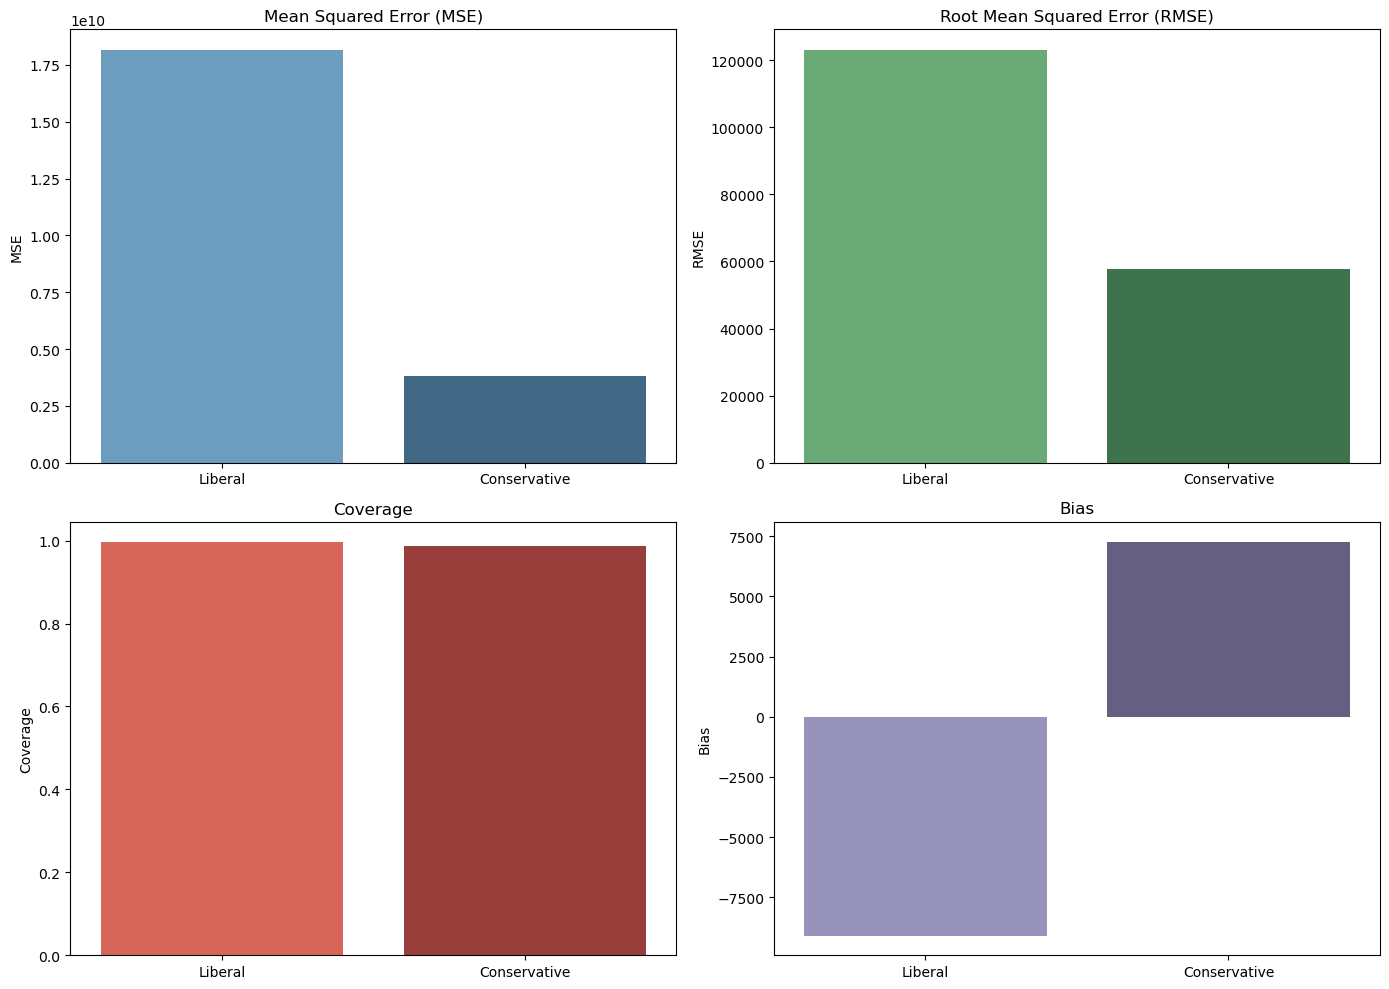

In [664]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create subplots for each metric
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot MSE
sns.barplot(x=['Liberal', 'Conservative'], y=[mean_liberal_mse, mean_conservative_mse], ax=axes[0, 0], palette="Blues_d")
axes[0, 0].set_title('Mean Squared Error (MSE)')
axes[0, 0].set_ylabel('MSE')

# Plot RMSE
sns.barplot(x=['Liberal', 'Conservative'], y=[mean_liberal_rmse, mean_conservative_rmse], ax=axes[0, 1], palette="Greens_d")
axes[0, 1].set_title('Root Mean Squared Error (RMSE)')
axes[0, 1].set_ylabel('RMSE')

# Plot Coverage
sns.barplot(x=['Liberal', 'Conservative'], y=[mean_liberal_coverage, mean_conservative_coverage], ax=axes[1, 0], palette="Reds_d")
axes[1, 0].set_title('Coverage')
axes[1, 0].set_ylabel('Coverage')

# Plot Bias
sns.barplot(x=['Liberal', 'Conservative'], y=[mean_liberal_bias, mean_conservative_bias], ax=axes[1, 1], palette="Purples_d")
axes[1, 1].set_title('Bias')
axes[1, 1].set_ylabel('Bias')

# Adjust layout
plt.tight_layout()
plt.show()

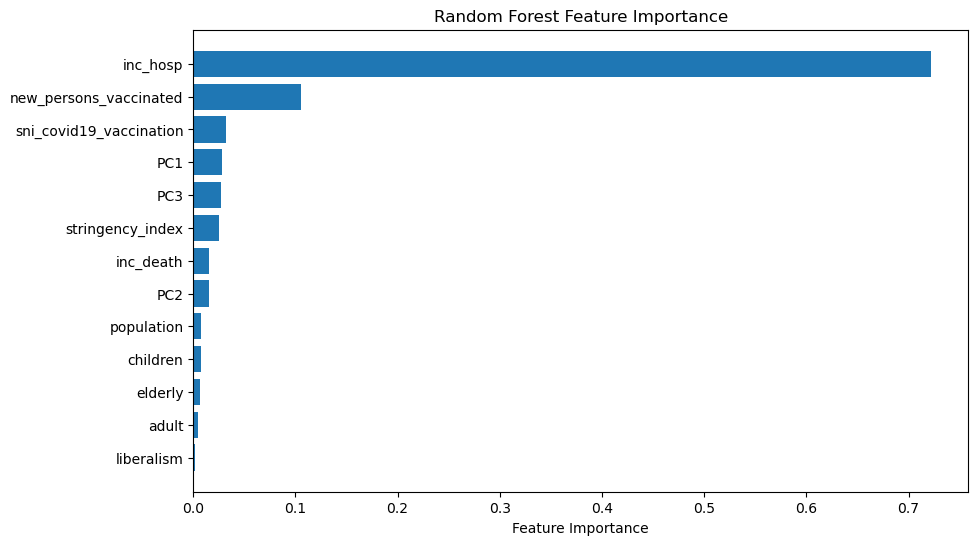

In [665]:
# Get feature importances from the random forest model
feature_importances = rf_model.feature_importances_

# Get the names of features
feature_names = list(X.columns)

# Sort features based on importance
sorted_idx = feature_importances.argsort()

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), feature_importances[sorted_idx], align="center")
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importance")
plt.show()

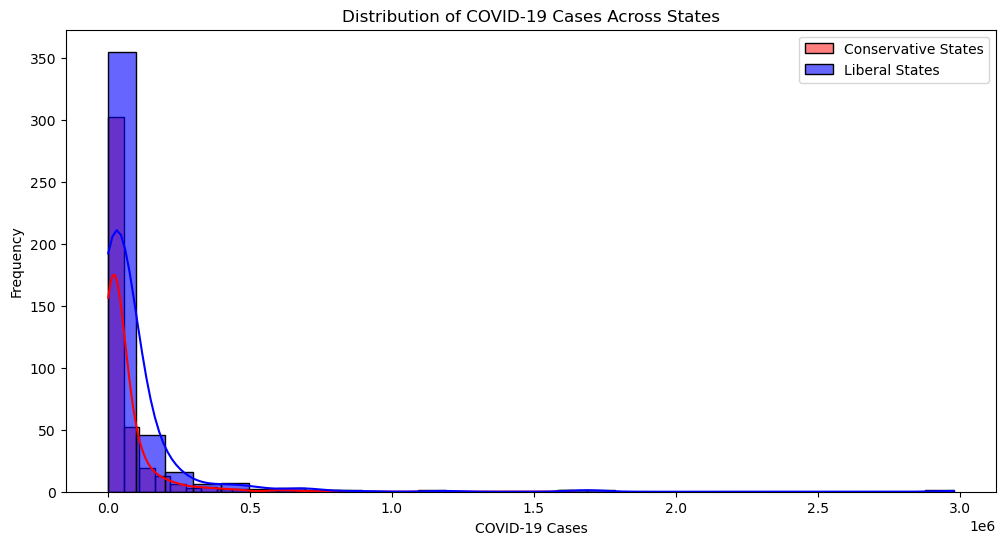

In [666]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))

conservative_states = df[df['liberalism'] == 0]
sns.histplot(conservative_states['inc_case'], color='red', label='Conservative States', kde=True, bins=30)

liberal_states = df[df['liberalism'] == 1]
sns.histplot(liberal_states['inc_case'], color='blue', label='Liberal States', kde=True, bins=30, alpha=0.6)

plt.title('Distribution of COVID-19 Cases Across States')
plt.xlabel('COVID-19 Cases')
plt.ylabel('Frequency')
plt.legend()

plt.show()

#### Method 2: Conditional Independent Demographic Parity

#### STEP 2.1: Create an interaction variable

In [667]:
df['int:liberalism_stringency'] = df['liberalism'] * df['stringency_category']

display(df)

,date,location_key,inc_case,inc_hosp,inc_death,sni_covid19_vaccination,liberalism,children,adult,elderly,...,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,population,PC1,PC2,PC3,int:liberalism_stringency
0,2021-01,Alabama,112124.0,1.371155,1.584112,0.032568,0.0,-0.231951,-0.237370,-0.199080,...,-1.239613,-1.010675,-0.710112,-0.403022,1.149867,-0.214890,-2.396417,-0.262114,-0.155315,0.0
1,2021-02,Alabama,37101.0,0.126002,1.194710,0.473211,0.0,-0.231951,-0.237370,-0.199080,...,-0.898820,-1.003504,-0.668582,0.006228,0.932787,-0.214890,-1.972958,-0.522742,0.003450,0.0
2,2021-03,Alabama,21389.0,-0.262578,-0.136938,0.761413,0.0,-0.231951,-0.237370,-0.199080,...,-0.186514,-0.539392,0.198196,0.400880,-0.313185,-0.214890,0.139648,-0.682227,-0.173175,0.0
3,2021-04,Alabama,11826.0,-0.305176,-0.341053,0.151403,0.0,-0.231951,-0.237370,-0.199080,...,0.280345,-0.245660,0.596958,0.505887,-0.860254,-0.214890,1.069035,-0.646917,-0.263173,0.0
4,2021-05,Alabama,17507.0,-0.310958,-0.363649,-0.620656,0.0,-0.231951,-0.237370,-0.199080,...,0.795346,-0.132359,0.702473,0.406098,-0.821837,-0.214890,1.286734,-0.405888,-0.361615,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
844,2022-01,Wyoming,30284.0,-0.490021,-0.511275,-0.187515,0.0,-0.784307,-0.790295,-0.844465,...,-1.791613,-0.812955,-0.136998,0.086861,0.160913,-0.097436,-1.830921,-1.051324,-0.191443,0.0
845,2022-02,Wyoming,10383.0,-0.525872,-0.515795,-1.189568,0.0,-0.784307,-0.790295,-0.844465,...,-1.425853,-0.668646,-0.013136,0.763481,-0.748702,-0.097436,-0.700890,-1.545408,0.161265,0.0
846,2022-03,Wyoming,1147.0,-0.560374,-0.536884,-1.245098,0.0,-0.784307,-0.790295,-0.844465,...,-1.621355,-0.466161,0.242183,0.732437,-1.141553,-0.097436,-0.412656,-1.610823,0.084658,0.0
847,2022-04,Wyoming,494.0,-0.568470,-0.563999,-1.285458,0.0,-0.784307,-0.790295,-0.844465,...,-1.414245,-0.270519,0.001928,0.601806,-1.420710,-0.097436,-0.196359,-1.357435,0.332745,0.0


#### STEP 2.2: Define features

In [668]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

X = df[['sni_covid19_vaccination','new_persons_vaccinated', 'stringency_category', 'inc_death',
        'PC1', 'PC2', 'PC3', 'inc_hosp', 'children', 'adult', 'elderly', 'liberalism', 'population', 'int:liberalism_stringency']]
y = df['inc_case']
sensitive_feature = df['liberalism']

#### STEP 2.4: Calculate Demographic Parity using StratifiedKFold

In [669]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import StratifiedKFold
import numpy as np

# Initialize StratifiedKFold with 5 splits
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store predictions, true values, and sensitive features for each fold
y_pred_list = []
y_true_list = []
X_test_list = []
sensitive_feature_list = []

# List to store MAE for liberal and conservative states in each fold
liberal_mae_list = []
conservative_mae_list = []

# Loop through each fold of StratifiedKFold
for train_index, test_index in skf.split(X, sensitive_feature):

    # Split the data into training and testing sets for this fold
    # Ensures that each fold has a similar proportion of liberal and conservative states as the overall dataset
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Store X_test for this fold
    X_test_list.append(X_test)

    # Train RandomForestRegressor on the training data
    rf_model = RandomForestRegressor(random_state=42)
    rf_model.fit(X_train, y_train)

    # Predict on the test data
    y_pred = rf_model.predict(X_test)
    y_pred_list.append(y_pred)
    y_true_list.append(y_test)
    sensitive_feature_list.append(sensitive_feature.iloc[test_index])

    # Convert y_pred to a pandas Series with the same index as y_test
    y_pred_series = pd.Series(y_pred, index=y_test.index)

    # Separate the predictions into liberal and conservative states
    liberal_indices = X_test[sensitive_feature.iloc[test_index] == 1].index
    conservative_indices = X_test[sensitive_feature.iloc[test_index] == 0].index

    # Calculate MAE for liberal (blue) states
    liberal_mae = mean_absolute_error(y_test.loc[liberal_indices], y_pred_series.loc[liberal_indices])
    liberal_mae_list.append(liberal_mae)

    # Calculate MAE for conservative (red) states
    conservative_mae = mean_absolute_error(y_test.loc[conservative_indices], y_pred_series.loc[conservative_indices])
    conservative_mae_list.append(conservative_mae)

# Calculate the mean and standard deviation of the MAEs
mean_liberal_mae = np.mean(liberal_mae_list)
mean_conservative_mae = np.mean(conservative_mae_list)
mae_difference = mean_liberal_mae - mean_conservative_mae

print(f"Mean MAE for liberal (blue) states: {mean_liberal_mae}")
print(f"Mean MAE for conservative (red) states: {mean_conservative_mae}")
print(f"Difference in MAE (liberal - conservative): {mae_difference}")

Mean MAE for liberal (blue) states: 37463.557754596535
Mean MAE for conservative (red) states: 22463.876687142427
Difference in MAE (liberal - conservative): 14999.681067454108


#### STEP 2.5: Calculate differences between evaluation metrics between liberal (blue) and conservative (red) states

In [670]:
# Lists to store evaluation metrics for liberal and conservative states in each fold
liberal_mse_list = []
liberal_rmse_list = []
liberal_coverage_list = []
liberal_bias_list = []

conservative_mse_list = []
conservative_rmse_list = []
conservative_coverage_list = []
conservative_bias_list = []

# Loop through each fold of StratifiedKFold
for fold_idx, (train_index, test_index) in enumerate(skf.split(X, sensitive_feature)):
    # Get predictions from the first part
    y_pred = y_pred_list[fold_idx]
    y_test = y_true_list[fold_idx]
    sensitive_feature = sensitive_feature_list[fold_idx]

    # Calculate RMSE, coverage, and bias for liberal and conservative states
    liberal_indices = sensitive_feature == 1
    conservative_indices = sensitive_feature == 0

    liberal_mse = mean_squared_error(y_test[liberal_indices], y_pred[liberal_indices])
    liberal_rmse = np.sqrt(liberal_mse)
    liberal_coverage, liberal_bias = calculate_coverage_bias(y_test[liberal_indices], y_pred[liberal_indices])

    conservative_mse = mean_squared_error(y_test[conservative_indices], y_pred[conservative_indices])
    conservative_rmse = np.sqrt(conservative_mse)
    conservative_coverage, conservative_bias = calculate_coverage_bias(y_test[conservative_indices], y_pred[conservative_indices])

    # Append evaluation metrics to the corresponding lists
    liberal_mse_list.append(liberal_mse)
    liberal_rmse_list.append(liberal_rmse)
    liberal_coverage_list.append(liberal_coverage)
    liberal_bias_list.append(liberal_bias)

    conservative_mse_list.append(conservative_mse)
    conservative_rmse_list.append(conservative_rmse)
    conservative_coverage_list.append(conservative_coverage)
    conservative_bias_list.append(conservative_bias)

# Calculate the mean and standard deviation of the evaluation metrics
mean_liberal_mse = np.mean(liberal_mse_list)
mean_liberal_rmse = np.mean(liberal_rmse_list)
mean_liberal_coverage = np.mean(liberal_coverage_list)
mean_liberal_bias = np.mean(liberal_bias_list)

mean_conservative_mse = np.mean(conservative_mse_list)
mean_conservative_rmse = np.mean(conservative_rmse_list)
mean_conservative_coverage = np.mean(conservative_coverage_list)
mean_conservative_bias = np.mean(conservative_bias_list)

# Print the results
print("Metrics for Liberal (Blue) States:")
print("Mean MSE:", mean_liberal_mse)
print("Mean RMSE:", mean_liberal_rmse)
print("Mean Coverage:", mean_liberal_coverage)
print("Mean Bias:", mean_liberal_bias)
print("\nMetrics for Conservative (Red) States:")
print("Mean MSE:", mean_conservative_mse)
print("Mean RMSE:", mean_conservative_rmse)
print("Mean Coverage:", mean_conservative_coverage)
print("Mean Bias:", mean_conservative_bias)

Metrics for Liberal (Blue) States:
Mean MSE: 18652350258.791775
Mean RMSE: 125301.40829063598
Mean Coverage: 0.9954545454545455
Mean Bias: -9038.332333248214

Metrics for Conservative (Red) States:
Mean MSE: 3764887102.4591956
Mean RMSE: 56474.09796293931
Mean Coverage: 0.9877145438121048
Mean Bias: 7135.818884673291


In [671]:
# Create a DataFrame to store the mean evaluation metrics
metrics_df = pd.DataFrame({
    'Metric': ['MSE', 'RMSE', 'Coverage', 'Bias'],
    'Liberal (Blue) States': [mean_liberal_mse, mean_liberal_rmse, mean_liberal_coverage, mean_liberal_bias],
    'Conservative (Red) States': [mean_conservative_mse, mean_conservative_rmse, mean_conservative_coverage, mean_conservative_bias]
})

metrics_df['Difference'] = metrics_df['Liberal (Blue) States'] - metrics_df['Conservative (Red) States']

# Print the DataFrame
display(metrics_df)

,Metric,Liberal (Blue) States,Conservative (Red) States,Difference
0,MSE,1.865235e+10,3.764887e+09,1.488746e+10
1,RMSE,1.253014e+05,5.647410e+04,6.882731e+04
2,Coverage,9.954545e-01,9.877145e-01,7.740002e-03
3,Bias,-9.038332e+03,7.135819e+03,-1.617415e+04


#### STEP 2.6: Calculate the difference in evaluation metrics between liberal and conservative states based on the stringency index

In [672]:
import pandas as pd

# Interaction groups
interaction_groups = [
    (1, 1),
    (1, 2),
    (1, 3),
    (0, 1),
    (0, 2),
    (0, 3)
]

# Dictionary to store results for interaction groups
interaction_results = {group: {'y_true': [], 'y_pred': []} for group in interaction_groups}

# Loop through each fold's stored predictions and true values
for fold_index in range(len(y_true_list)):
    X_test = X_test_list[fold_index]
    y_test = y_true_list[fold_index]
    y_pred = y_pred_list[fold_index]

    # Store predictions and true values for interaction groups
    for liberalism, stringency in interaction_results.keys():
        group_mask = (X_test['liberalism'] == liberalism) & (X_test['stringency_category'] == stringency)
        interaction_results[(liberalism, stringency)]['y_true'].extend(y_test[group_mask].tolist())
        interaction_results[(liberalism, stringency)]['y_pred'].extend(y_pred[group_mask].tolist())

# Calculate metrics for interaction groups
interaction_metrics = []
for group, values in interaction_results.items():
    y_true = np.array(values['y_true'])
    y_pred = np.array(values['y_pred'])
    if len(y_true) > 0:
        rmse = mean_squared_error(y_true, y_pred, squared=False)
        mse = mean_squared_error(y_true, y_pred)
        bias = (y_pred - y_true).mean()
        coverage = ((y_pred >= y_true.min()) & (y_pred <= y_true.max())).mean()
        interaction_metrics.append({
            'Political Affiliation': 'Liberal' if group[0] == 1 else 'Conservative',
            'Stringency Category': group[1],
            'RMSE': rmse,
            'MSE': mse,
            'Bias': bias,
            'Coverage': coverage
        })

# Convert interaction metrics to DataFrame
interaction_df = pd.DataFrame(interaction_metrics)

# Calculate the difference between liberal and conservative groups based on the stringency category
interaction_df['Diff_RMSE'] = interaction_df.groupby('Stringency Category')['RMSE'].diff()
interaction_df['Diff_MSE'] = interaction_df.groupby('Stringency Category')['MSE'].diff()
interaction_df['Diff_Bias'] = interaction_df.groupby('Stringency Category')['Bias'].diff()
interaction_df['Diff_Coverage'] = interaction_df.groupby('Stringency Category')['Coverage'].diff()

# Print the DataFrame
display(interaction_df)

,Political Affiliation,Stringency Category,RMSE,MSE,Bias,Coverage,Diff_RMSE,Diff_MSE,Diff_Bias,Diff_Coverage
0,Liberal,1,90818.802194,8.248055e+09,-11490.631739,1.000000,NaN,NaN,NaN,NaN
1,Liberal,2,211347.948457,4.466796e+10,-17004.060866,1.000000,NaN,NaN,NaN,NaN
2,Liberal,3,85250.796134,7.267698e+09,35176.660263,1.000000,NaN,NaN,NaN,NaN
3,Conservative,1,65474.955380,4.286970e+09,2774.486700,1.000000,-25343.846814,-3.961085e+09,14265.118439,0.000000
4,Conservative,2,47343.519347,2.241409e+09,20922.874624,0.978495,-164004.429110,-4.242655e+10,37926.935490,-0.021505
5,Conservative,3,49870.426059,2.487059e+09,9554.350000,1.000000,-35380.370075,-4.780639e+09,-25622.310263,0.000000


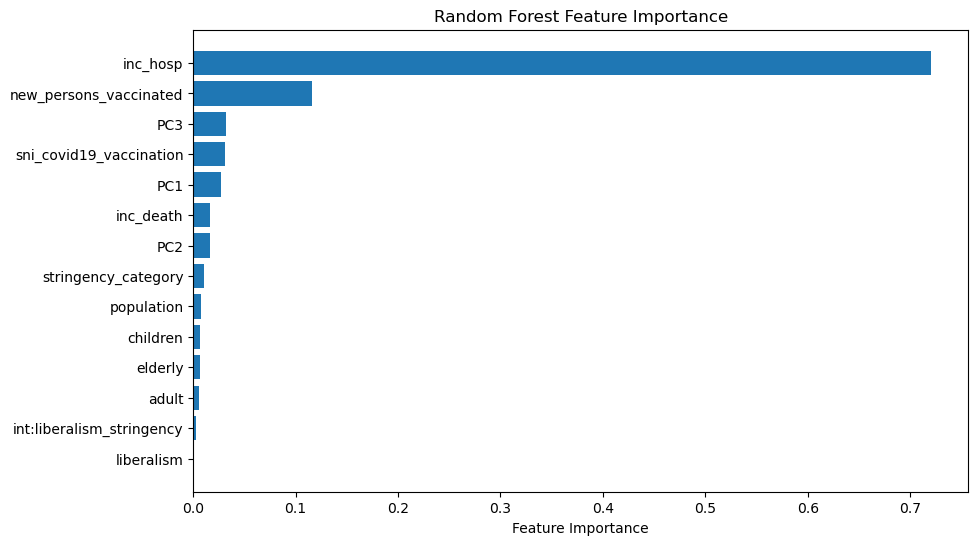

In [673]:
# Get feature importances from the random forest model
feature_importances = rf_model.feature_importances_

# Get the names of features
feature_names = list(X.columns)

# Sort features based on importance
sorted_idx = feature_importances.argsort()

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), feature_importances[sorted_idx], align="center")
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importance")
plt.show()

### Mitigating Bias

#### **Reweight model for each StratifiedKFold and calculate Demographic Parity** 

In [674]:
# Define features and target variable
X = df[['sni_covid19_vaccination', 'new_persons_vaccinated', 'stringency_index', 'inc_death',
        'PC1', 'PC2', 'PC3', 'inc_hosp', 'children', 'adult', 'elderly', 'population']]
y = df['inc_case']
sensitive_feature = df['liberalism']

# Initialize StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store predictions and true values for each fold
y_pred_list = []
y_true_list = []
liberal_mae_list = []
conservative_mae_list = []

for train_index, test_index in skf.split(X, sensitive_feature):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Calculate the sample weights based on the training data
    liberal_count_train = sum(df.loc[X_train.index]['liberalism'] == 1)
    conservative_count_train = sum(df.loc[X_train.index]['liberalism'] == 0)

    liberal_weight_train = (1 / liberal_count_train) ** 0.5
    conservative_weight_train = (1 / conservative_count_train) ** 0.5

    # Assign sample weights
    sample_weight_train = np.array([liberal_weight_train if label == 1 else conservative_weight_train for label in df.loc[X_train.index]['liberalism']])
    
    # Train RandomForestRegressor with reweighting
    rf_model = RandomForestRegressor(random_state=42)
    rf_model.fit(X_train, y_train, sample_weight=sample_weight_train)
    y_pred = rf_model.predict(X_test)

    y_pred_list.append(y_pred)
    y_true_list.append(y_test)

    # Convert y_pred to a pandas Series with the same index as y_test
    y_pred_series = pd.Series(y_pred, index=y_test.index)

    # Separate the predictions into red and blue states
    liberal_indices = X_test[df.loc[X_test.index]['liberalism'] == 1].index
    conservative_indices = X_test[df.loc[X_test.index]['liberalism'] == 0].index

    # Calculate MAE for liberal (blue) states
    liberal_mae = mean_absolute_error(y_test.loc[liberal_indices], y_pred_series.loc[liberal_indices])
    liberal_mae_list.append(liberal_mae)

    # Calculate MAE for conservative (red) states
    conservative_mae = mean_absolute_error(y_test.loc[conservative_indices], y_pred_series.loc[conservative_indices])
    conservative_mae_list.append(conservative_mae)

# Calculate the mean and standard deviation of the MAEs
mean_liberal_mae = np.mean(liberal_mae_list)
mean_conservative_mae = np.mean(conservative_mae_list)
mae_difference = mean_liberal_mae - mean_conservative_mae

print(f"Mean MAE for liberal (blue) states: {mean_liberal_mae}")
print(f"Mean MAE for conservative (red) states: {mean_conservative_mae}")
print(f"Difference in MAE (liberal - conservative): {mae_difference}")

Mean MAE for liberal (blue) states: 36626.22379009193
Mean MAE for conservative (red) states: 22900.830331225538
Difference in MAE (liberal - conservative): 13725.39345886639


In [675]:
# Lists to store evaluation metrics for liberal and conservative states in each fold
liberal_mse_list = []
liberal_rmse_list = []
liberal_coverage_list = []
liberal_bias_list = []

conservative_mse_list = []
conservative_rmse_list = []
conservative_coverage_list = []
conservative_bias_list = []

# Loop through each fold of StratifiedKFold
for fold_idx, (train_index, test_index) in enumerate(skf.split(X, sensitive_feature)):
    # Get predictions from the first part
    y_pred = y_pred_list[fold_idx]
    y_test = y_true_list[fold_idx]
    sensitive_feature = sensitive_feature_list[fold_idx]

    # Calculate RMSE, coverage, and bias for liberal and conservative states
    liberal_indices = sensitive_feature == 1
    conservative_indices = sensitive_feature == 0

    liberal_mse = mean_squared_error(y_test[liberal_indices], y_pred[liberal_indices])
    liberal_rmse = np.sqrt(liberal_mse)
    liberal_coverage, liberal_bias = calculate_coverage_bias(y_test[liberal_indices], y_pred[liberal_indices])

    conservative_mse = mean_squared_error(y_test[conservative_indices], y_pred[conservative_indices])
    conservative_rmse = np.sqrt(conservative_mse)
    conservative_coverage, conservative_bias = calculate_coverage_bias(y_test[conservative_indices], y_pred[conservative_indices])

    # Append evaluation metrics to the corresponding lists
    liberal_mse_list.append(liberal_mse)
    liberal_rmse_list.append(liberal_rmse)
    liberal_coverage_list.append(liberal_coverage)
    liberal_bias_list.append(liberal_bias)

    conservative_mse_list.append(conservative_mse)
    conservative_rmse_list.append(conservative_rmse)
    conservative_coverage_list.append(conservative_coverage)
    conservative_bias_list.append(conservative_bias)

# Calculate the mean and standard deviation of the evaluation metrics
mean_liberal_mse = np.mean(liberal_mse_list)
mean_liberal_rmse = np.mean(liberal_rmse_list)
mean_liberal_coverage = np.mean(liberal_coverage_list)
mean_liberal_bias = np.mean(liberal_bias_list)

mean_conservative_mse = np.mean(conservative_mse_list)
mean_conservative_rmse = np.mean(conservative_rmse_list)
mean_conservative_coverage = np.mean(conservative_coverage_list)
mean_conservative_bias = np.mean(conservative_bias_list)

# Print the results
print("Metrics for Liberal (Blue) States:")
print("Mean MSE:", mean_liberal_mse)
print("Mean RMSE:", mean_liberal_rmse)
print("Mean Coverage:", mean_liberal_coverage)
print("Mean Bias:", mean_liberal_bias)
print("\nMetrics for Conservative (Red) States:")
print("Mean MSE:", mean_conservative_mse)
print("Mean RMSE:", mean_conservative_rmse)
print("Mean Coverage:", mean_conservative_coverage)
print("Mean Bias:", mean_conservative_bias)

Metrics for Liberal (Blue) States:
Mean MSE: 18286261202.705704
Mean RMSE: 123058.43829952995
Mean Coverage: 0.9977272727272727
Mean Bias: -9978.487558733403

Metrics for Conservative (Red) States:
Mean MSE: 3899408515.4372253
Mean RMSE: 57933.75214682009
Mean Coverage: 0.9852454080096356
Mean Bias: 7327.207881361035


In [676]:
# Create a DataFrame to store the mean evaluation metrics
metrics_df = pd.DataFrame({
    'Metric': ['MSE', 'RMSE', 'Coverage', 'Bias'],
    'Liberal (Blue) States': [mean_liberal_mse, mean_liberal_rmse, mean_liberal_coverage, mean_liberal_bias],
    'Conservative (Red) States': [mean_conservative_mse, mean_conservative_rmse, mean_conservative_coverage, mean_conservative_bias]
})

metrics_df['Difference'] = metrics_df['Liberal (Blue) States'] - metrics_df['Conservative (Red) States']

# Print the DataFrame
display(metrics_df)

,Metric,Liberal (Blue) States,Conservative (Red) States,Difference
0,MSE,1.828626e+10,3.899409e+09,1.438685e+10
1,RMSE,1.230584e+05,5.793375e+04,6.512469e+04
2,Coverage,9.977273e-01,9.852454e-01,1.248186e-02
3,Bias,-9.978488e+03,7.327208e+03,-1.730570e+04


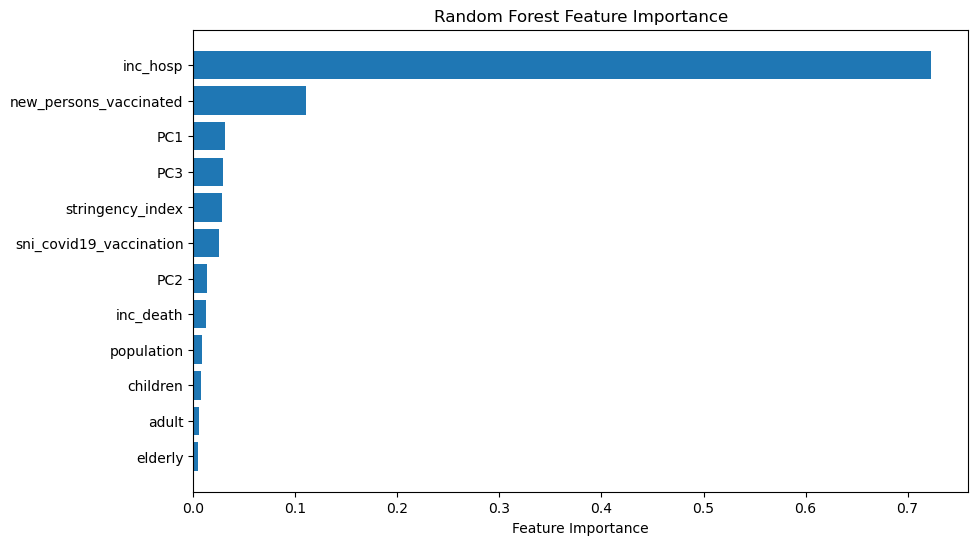

In [677]:
# Get feature importances from the random forest model
feature_importances = rf_model.feature_importances_

# Get the names of features
feature_names = list(X.columns)

# Sort features based on importance
sorted_idx = feature_importances.argsort()

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), feature_importances[sorted_idx], align="center")
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importance")
plt.show()

#### **EXTRA: Try to add interaction variables**

#### Create an interaction variable

In [678]:
df['int:liberalism_stringency'] = df['liberalism'] * df['stringency_category']
df['int:liberalsim_new_persons_vaccinated'] = df['liberalism'] * df['new_persons_vaccinated']
df['int:population__stringency'] = df['population'] * df['stringency_category']

display(df)

,date,location_key,inc_case,inc_hosp,inc_death,sni_covid19_vaccination,liberalism,children,adult,elderly,...,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,population,PC1,PC2,PC3,int:liberalism_stringency,int:liberalsim_new_persons_vaccinated,int:population__stringency
0,2021-01,Alabama,112124.0,1.371155,1.584112,0.032568,0.0,-0.231951,-0.237370,-0.199080,...,-0.710112,-0.403022,1.149867,-0.214890,-2.396417,-0.262114,-0.155315,0.0,-0.0,-0.429781
1,2021-02,Alabama,37101.0,0.126002,1.194710,0.473211,0.0,-0.231951,-0.237370,-0.199080,...,-0.668582,0.006228,0.932787,-0.214890,-1.972958,-0.522742,0.003450,0.0,0.0,-0.429781
2,2021-03,Alabama,21389.0,-0.262578,-0.136938,0.761413,0.0,-0.231951,-0.237370,-0.199080,...,0.198196,0.400880,-0.313185,-0.214890,0.139648,-0.682227,-0.173175,0.0,0.0,-0.429781
3,2021-04,Alabama,11826.0,-0.305176,-0.341053,0.151403,0.0,-0.231951,-0.237370,-0.199080,...,0.596958,0.505887,-0.860254,-0.214890,1.069035,-0.646917,-0.263173,0.0,0.0,-0.214890
4,2021-05,Alabama,17507.0,-0.310958,-0.363649,-0.620656,0.0,-0.231951,-0.237370,-0.199080,...,0.702473,0.406098,-0.821837,-0.214890,1.286734,-0.405888,-0.361615,0.0,-0.0,-0.214890
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
844,2022-01,Wyoming,30284.0,-0.490021,-0.511275,-0.187515,0.0,-0.784307,-0.790295,-0.844465,...,-0.136998,0.086861,0.160913,-0.097436,-1.830921,-1.051324,-0.191443,0.0,-0.0,-0.097436
845,2022-02,Wyoming,10383.0,-0.525872,-0.515795,-1.189568,0.0,-0.784307,-0.790295,-0.844465,...,-0.013136,0.763481,-0.748702,-0.097436,-0.700890,-1.545408,0.161265,0.0,-0.0,-0.097436
846,2022-03,Wyoming,1147.0,-0.560374,-0.536884,-1.245098,0.0,-0.784307,-0.790295,-0.844465,...,0.242183,0.732437,-1.141553,-0.097436,-0.412656,-1.610823,0.084658,0.0,-0.0,-0.097436
847,2022-04,Wyoming,494.0,-0.568470,-0.563999,-1.285458,0.0,-0.784307,-0.790295,-0.844465,...,0.001928,0.601806,-1.420710,-0.097436,-0.196359,-1.357435,0.332745,0.0,-0.0,-0.097436


#### Define features

In [679]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

X = df[['sni_covid19_vaccination','new_persons_vaccinated', 'stringency_category', 'inc_death',
        'PC1', 'PC2', 'PC3', 'inc_hosp', 'children', 'adult', 'elderly', 'liberalism', 'population', 
        'int:liberalism_stringency', 'int:liberalsim_new_persons_vaccinated', 'int:population__stringency']]
y = df['inc_case']
sensitive_feature = df['liberalism']

#### Calculate Demographic Parity using StratifiedKFold

In [680]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import StratifiedKFold
import numpy as np

# Initialize StratifiedKFold with 5 splits
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store predictions, true values, and sensitive features for each fold
y_pred_list = []
y_true_list = []
X_test_list = []
sensitive_feature_list = []

# List to store MAE for liberal and conservative states in each fold
liberal_mae_list = []
conservative_mae_list = []

# Loop through each fold of StratifiedKFold
for train_index, test_index in skf.split(X, sensitive_feature):

    # Split the data into training and testing sets for this fold
    # Ensures that each fold has a similar proportion of liberal and conservative states as the overall dataset
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Store X_test for this fold
    X_test_list.append(X_test)

    # Train RandomForestRegressor on the training data
    rf_model = RandomForestRegressor(random_state=42)
    rf_model.fit(X_train, y_train)

    # Predict on the test data
    y_pred = rf_model.predict(X_test)
    y_pred_list.append(y_pred)
    y_true_list.append(y_test)
    sensitive_feature_list.append(sensitive_feature.iloc[test_index])

    # Convert y_pred to a pandas Series with the same index as y_test
    y_pred_series = pd.Series(y_pred, index=y_test.index)

    # Separate the predictions into liberal and conservative states
    liberal_indices = X_test[sensitive_feature.iloc[test_index] == 1].index
    conservative_indices = X_test[sensitive_feature.iloc[test_index] == 0].index

    # Calculate MAE for liberal (blue) states
    liberal_mae = mean_absolute_error(y_test.loc[liberal_indices], y_pred_series.loc[liberal_indices])
    liberal_mae_list.append(liberal_mae)

    # Calculate MAE for conservative (red) states
    conservative_mae = mean_absolute_error(y_test.loc[conservative_indices], y_pred_series.loc[conservative_indices])
    conservative_mae_list.append(conservative_mae)

# Calculate the mean and standard deviation of the MAEs
mean_liberal_mae = np.mean(liberal_mae_list)
mean_conservative_mae = np.mean(conservative_mae_list)
mae_difference = mean_liberal_mae - mean_conservative_mae

print(f"Mean MAE for liberal (blue) states: {mean_liberal_mae}")
print(f"Mean MAE for conservative (red) states: {mean_conservative_mae}")
print(f"Difference in MAE (liberal - conservative): {mae_difference}")

Mean MAE for liberal (blue) states: 37526.69626302349
Mean MAE for conservative (red) states: 22367.907633544113
Difference in MAE (liberal - conservative): 15158.788629479379


#### Calculate differences between evaluation metrics between liberal (blue) and conservative (red) states

In [681]:
# Lists to store evaluation metrics for liberal and conservative states in each fold
liberal_mse_list = []
liberal_rmse_list = []
liberal_coverage_list = []
liberal_bias_list = []

conservative_mse_list = []
conservative_rmse_list = []
conservative_coverage_list = []
conservative_bias_list = []

# Loop through each fold of StratifiedKFold
for fold_idx, (train_index, test_index) in enumerate(skf.split(X, sensitive_feature)):
    # Get predictions from the first part
    y_pred = y_pred_list[fold_idx]
    y_test = y_true_list[fold_idx]
    sensitive_feature = sensitive_feature_list[fold_idx]

    # Calculate RMSE, coverage, and bias for liberal and conservative states
    liberal_indices = sensitive_feature == 1
    conservative_indices = sensitive_feature == 0

    liberal_mse = mean_squared_error(y_test[liberal_indices], y_pred[liberal_indices])
    liberal_rmse = np.sqrt(liberal_mse)
    liberal_coverage, liberal_bias = calculate_coverage_bias(y_test[liberal_indices], y_pred[liberal_indices])

    conservative_mse = mean_squared_error(y_test[conservative_indices], y_pred[conservative_indices])
    conservative_rmse = np.sqrt(conservative_mse)
    conservative_coverage, conservative_bias = calculate_coverage_bias(y_test[conservative_indices], y_pred[conservative_indices])

    # Append evaluation metrics to the corresponding lists
    liberal_mse_list.append(liberal_mse)
    liberal_rmse_list.append(liberal_rmse)
    liberal_coverage_list.append(liberal_coverage)
    liberal_bias_list.append(liberal_bias)

    conservative_mse_list.append(conservative_mse)
    conservative_rmse_list.append(conservative_rmse)
    conservative_coverage_list.append(conservative_coverage)
    conservative_bias_list.append(conservative_bias)

# Calculate the mean and standard deviation of the evaluation metrics
mean_liberal_mse = np.mean(liberal_mse_list)
mean_liberal_rmse = np.mean(liberal_rmse_list)
mean_liberal_coverage = np.mean(liberal_coverage_list)
mean_liberal_bias = np.mean(liberal_bias_list)

mean_conservative_mse = np.mean(conservative_mse_list)
mean_conservative_rmse = np.mean(conservative_rmse_list)
mean_conservative_coverage = np.mean(conservative_coverage_list)
mean_conservative_bias = np.mean(conservative_bias_list)

# Print the results
print("Metrics for Liberal (Blue) States:")
print("Mean MSE:", mean_liberal_mse)
print("Mean RMSE:", mean_liberal_rmse)
print("Mean Coverage:", mean_liberal_coverage)
print("Mean Bias:", mean_liberal_bias)
print("\nMetrics for Conservative (Red) States:")
print("Mean MSE:", mean_conservative_mse)
print("Mean RMSE:", mean_conservative_rmse)
print("Mean Coverage:", mean_conservative_coverage)
print("Mean Bias:", mean_conservative_bias)

Metrics for Liberal (Blue) States:
Mean MSE: 18828295446.737236
Mean RMSE: 125347.665678928
Mean Coverage: 0.9954545454545455
Mean Bias: -8216.927559244124

Metrics for Conservative (Red) States:
Mean MSE: 4046980672.985379
Mean RMSE: 58497.43894666728
Mean Coverage: 0.9852454080096356
Mean Bias: 5681.9761267690465


In [682]:
# Create a DataFrame to store the mean evaluation metrics
metrics_df = pd.DataFrame({
    'Metric': ['MSE', 'RMSE', 'Coverage', 'Bias'],
    'Liberal (Blue) States': [mean_liberal_mse, mean_liberal_rmse, mean_liberal_coverage, mean_liberal_bias],
    'Conservative (Red) States': [mean_conservative_mse, mean_conservative_rmse, mean_conservative_coverage, mean_conservative_bias]
})

metrics_df['Difference'] = metrics_df['Liberal (Blue) States'] - metrics_df['Conservative (Red) States']

# Print the DataFrame
display(metrics_df)

,Metric,Liberal (Blue) States,Conservative (Red) States,Difference
0,MSE,1.882830e+10,4.046981e+09,1.478131e+10
1,RMSE,1.253477e+05,5.849744e+04,6.685023e+04
2,Coverage,9.954545e-01,9.852454e-01,1.020914e-02
3,Bias,-8.216928e+03,5.681976e+03,-1.389890e+04


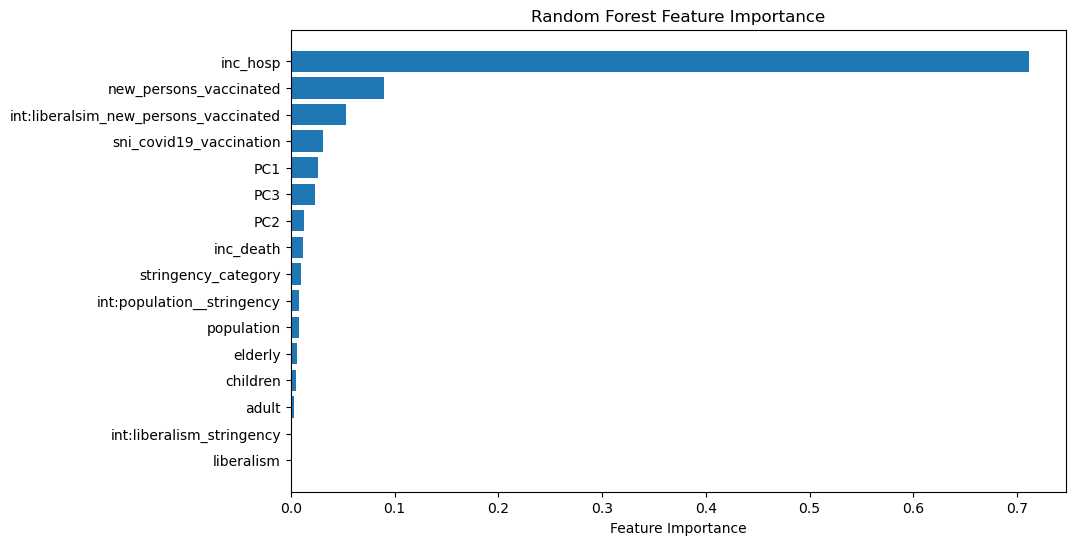

In [683]:
# Get feature importances from the random forest model
feature_importances = rf_model.feature_importances_

# Get the names of features
feature_names = list(X.columns)

# Sort features based on importance
sorted_idx = feature_importances.argsort()

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), feature_importances[sorted_idx], align="center")
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importance")
plt.show()

#### **EXTRA: Try to add human development index**

Human Development Index (HDI) is a composite index of life expectancy, education, and per capita income indicators.

In [684]:
HDI_df = pd.read_csv('GDL-Subnational-HDI-data.csv')

# Select only the necessary columns
HDI_df = HDI_df[['Region', '2021']].rename(columns={'Region': 'location_key', '2021': 'HDI'})
# Drop the first row (total HDI for the United States)
HDI_df = HDI_df.iloc[1:]
# Merge the HDI data with the original dataframe
df = pd.merge(df, HDI_df, on=['location_key'])

display(df)

,date,location_key,inc_case,inc_hosp,inc_death,sni_covid19_vaccination,liberalism,children,adult,elderly,...,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,population,PC1,PC2,PC3,int:liberalism_stringency,int:liberalsim_new_persons_vaccinated,int:population__stringency,HDI
0,2021-01,Alabama,112124.0,1.371155,1.584112,0.032568,0.0,-0.231951,-0.237370,-0.199080,...,-0.403022,1.149867,-0.214890,-2.396417,-0.262114,-0.155315,0.0,-0.0,-0.429781,0.881
1,2021-02,Alabama,37101.0,0.126002,1.194710,0.473211,0.0,-0.231951,-0.237370,-0.199080,...,0.006228,0.932787,-0.214890,-1.972958,-0.522742,0.003450,0.0,0.0,-0.429781,0.881
2,2021-03,Alabama,21389.0,-0.262578,-0.136938,0.761413,0.0,-0.231951,-0.237370,-0.199080,...,0.400880,-0.313185,-0.214890,0.139648,-0.682227,-0.173175,0.0,0.0,-0.429781,0.881
3,2021-04,Alabama,11826.0,-0.305176,-0.341053,0.151403,0.0,-0.231951,-0.237370,-0.199080,...,0.505887,-0.860254,-0.214890,1.069035,-0.646917,-0.263173,0.0,0.0,-0.214890,0.881
4,2021-05,Alabama,17507.0,-0.310958,-0.363649,-0.620656,0.0,-0.231951,-0.237370,-0.199080,...,0.406098,-0.821837,-0.214890,1.286734,-0.405888,-0.361615,0.0,-0.0,-0.214890,0.881
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
844,2022-01,Wyoming,30284.0,-0.490021,-0.511275,-0.187515,0.0,-0.784307,-0.790295,-0.844465,...,0.086861,0.160913,-0.097436,-1.830921,-1.051324,-0.191443,0.0,-0.0,-0.097436,0.932
845,2022-02,Wyoming,10383.0,-0.525872,-0.515795,-1.189568,0.0,-0.784307,-0.790295,-0.844465,...,0.763481,-0.748702,-0.097436,-0.700890,-1.545408,0.161265,0.0,-0.0,-0.097436,0.932
846,2022-03,Wyoming,1147.0,-0.560374,-0.536884,-1.245098,0.0,-0.784307,-0.790295,-0.844465,...,0.732437,-1.141553,-0.097436,-0.412656,-1.610823,0.084658,0.0,-0.0,-0.097436,0.932
847,2022-04,Wyoming,494.0,-0.568470,-0.563999,-1.285458,0.0,-0.784307,-0.790295,-0.844465,...,0.601806,-1.420710,-0.097436,-0.196359,-1.357435,0.332745,0.0,-0.0,-0.097436,0.932


#### Define features

In [685]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

X = df[['sni_covid19_vaccination','new_persons_vaccinated', 'stringency_category', 'inc_death',
        'PC1', 'PC2', 'PC3', 'inc_hosp', 'children', 'adult', 'elderly', 'liberalism', 'population', 'HDI']]
y = df['inc_case']
sensitive_feature = df['liberalism']

#### Calculate Demographic Parity using StratifiedKFold

In [686]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import StratifiedKFold
import numpy as np

# Initialize StratifiedKFold with 5 splits
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store predictions, true values, and sensitive features for each fold
y_pred_list = []
y_true_list = []
X_test_list = []
sensitive_feature_list = []

# List to store MAE for liberal and conservative states in each fold
liberal_mae_list = []
conservative_mae_list = []

# Loop through each fold of StratifiedKFold
for train_index, test_index in skf.split(X, sensitive_feature):

    # Split the data into training and testing sets for this fold
    # Ensures that each fold has a similar proportion of liberal and conservative states as the overall dataset
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Store X_test for this fold
    X_test_list.append(X_test)

    # Train RandomForestRegressor on the training data
    rf_model = RandomForestRegressor(random_state=42)
    rf_model.fit(X_train, y_train)

    # Predict on the test data
    y_pred = rf_model.predict(X_test)
    y_pred_list.append(y_pred)
    y_true_list.append(y_test)
    sensitive_feature_list.append(sensitive_feature.iloc[test_index])

    # Convert y_pred to a pandas Series with the same index as y_test
    y_pred_series = pd.Series(y_pred, index=y_test.index)

    # Separate the predictions into liberal and conservative states
    liberal_indices = X_test[sensitive_feature.iloc[test_index] == 1].index
    conservative_indices = X_test[sensitive_feature.iloc[test_index] == 0].index

    # Calculate MAE for liberal (blue) states
    liberal_mae = mean_absolute_error(y_test.loc[liberal_indices], y_pred_series.loc[liberal_indices])
    liberal_mae_list.append(liberal_mae)

    # Calculate MAE for conservative (red) states
    conservative_mae = mean_absolute_error(y_test.loc[conservative_indices], y_pred_series.loc[conservative_indices])
    conservative_mae_list.append(conservative_mae)

# Calculate the mean and standard deviation of the MAEs
mean_liberal_mae = np.mean(liberal_mae_list)
mean_conservative_mae = np.mean(conservative_mae_list)
mae_difference = mean_liberal_mae - mean_conservative_mae

print(f"Mean MAE for liberal (blue) states: {mean_liberal_mae}")
print(f"Mean MAE for conservative (red) states: {mean_conservative_mae}")
print(f"Difference in MAE (liberal - conservative): {mae_difference}")

Mean MAE for liberal (blue) states: 37638.00847242084
Mean MAE for conservative (red) states: 22375.633397470643
Difference in MAE (liberal - conservative): 15262.3750749502


#### Calculate differences between evaluation metrics between liberal (blue) and conservative (red) states

In [687]:
# Lists to store evaluation metrics for liberal and conservative states in each fold
liberal_mse_list = []
liberal_rmse_list = []
liberal_coverage_list = []
liberal_bias_list = []

conservative_mse_list = []
conservative_rmse_list = []
conservative_coverage_list = []
conservative_bias_list = []

# Loop through each fold of StratifiedKFold
for fold_idx, (train_index, test_index) in enumerate(skf.split(X, sensitive_feature)):
    # Get predictions from the first part
    y_pred = y_pred_list[fold_idx]
    y_test = y_true_list[fold_idx]
    sensitive_feature = sensitive_feature_list[fold_idx]

    # Calculate RMSE, coverage, and bias for liberal and conservative states
    liberal_indices = sensitive_feature == 1
    conservative_indices = sensitive_feature == 0

    liberal_mse = mean_squared_error(y_test[liberal_indices], y_pred[liberal_indices])
    liberal_rmse = np.sqrt(liberal_mse)
    liberal_coverage, liberal_bias = calculate_coverage_bias(y_test[liberal_indices], y_pred[liberal_indices])

    conservative_mse = mean_squared_error(y_test[conservative_indices], y_pred[conservative_indices])
    conservative_rmse = np.sqrt(conservative_mse)
    conservative_coverage, conservative_bias = calculate_coverage_bias(y_test[conservative_indices], y_pred[conservative_indices])

    # Append evaluation metrics to the corresponding lists
    liberal_mse_list.append(liberal_mse)
    liberal_rmse_list.append(liberal_rmse)
    liberal_coverage_list.append(liberal_coverage)
    liberal_bias_list.append(liberal_bias)

    conservative_mse_list.append(conservative_mse)
    conservative_rmse_list.append(conservative_rmse)
    conservative_coverage_list.append(conservative_coverage)
    conservative_bias_list.append(conservative_bias)

# Calculate the mean and standard deviation of the evaluation metrics
mean_liberal_mse = np.mean(liberal_mse_list)
mean_liberal_rmse = np.mean(liberal_rmse_list)
mean_liberal_coverage = np.mean(liberal_coverage_list)
mean_liberal_bias = np.mean(liberal_bias_list)

mean_conservative_mse = np.mean(conservative_mse_list)
mean_conservative_rmse = np.mean(conservative_rmse_list)
mean_conservative_coverage = np.mean(conservative_coverage_list)
mean_conservative_bias = np.mean(conservative_bias_list)

# Print the results
print("Metrics for Liberal (Blue) States:")
print("Mean MSE:", mean_liberal_mse)
print("Mean RMSE:", mean_liberal_rmse)
print("Mean Coverage:", mean_liberal_coverage)
print("Mean Bias:", mean_liberal_bias)
print("\nMetrics for Conservative (Red) States:")
print("Mean MSE:", mean_conservative_mse)
print("Mean RMSE:", mean_conservative_rmse)
print("Mean Coverage:", mean_conservative_coverage)
print("Mean Bias:", mean_conservative_bias)

Metrics for Liberal (Blue) States:
Mean MSE: 18368097263.77356
Mean RMSE: 124114.93071080682
Mean Coverage: 0.9954545454545455
Mean Bias: -8069.748718590398

Metrics for Conservative (Red) States:
Mean MSE: 3811088390.0638094
Mean RMSE: 56743.16302416256
Mean Coverage: 0.9852454080096356
Mean Bias: 6170.21667780789


In [688]:
# Create a DataFrame to store the mean evaluation metrics
metrics_df = pd.DataFrame({
    'Metric': ['MSE', 'RMSE', 'Coverage', 'Bias'],
    'Liberal (Blue) States': [mean_liberal_mse, mean_liberal_rmse, mean_liberal_coverage, mean_liberal_bias],
    'Conservative (Red) States': [mean_conservative_mse, mean_conservative_rmse, mean_conservative_coverage, mean_conservative_bias]
})

metrics_df['Difference'] = metrics_df['Liberal (Blue) States'] - metrics_df['Conservative (Red) States']

# Print the DataFrame
display(metrics_df)

,Metric,Liberal (Blue) States,Conservative (Red) States,Difference
0,MSE,1.836810e+10,3.811088e+09,1.455701e+10
1,RMSE,1.241149e+05,5.674316e+04,6.737177e+04
2,Coverage,9.954545e-01,9.852454e-01,1.020914e-02
3,Bias,-8.069749e+03,6.170217e+03,-1.423997e+04


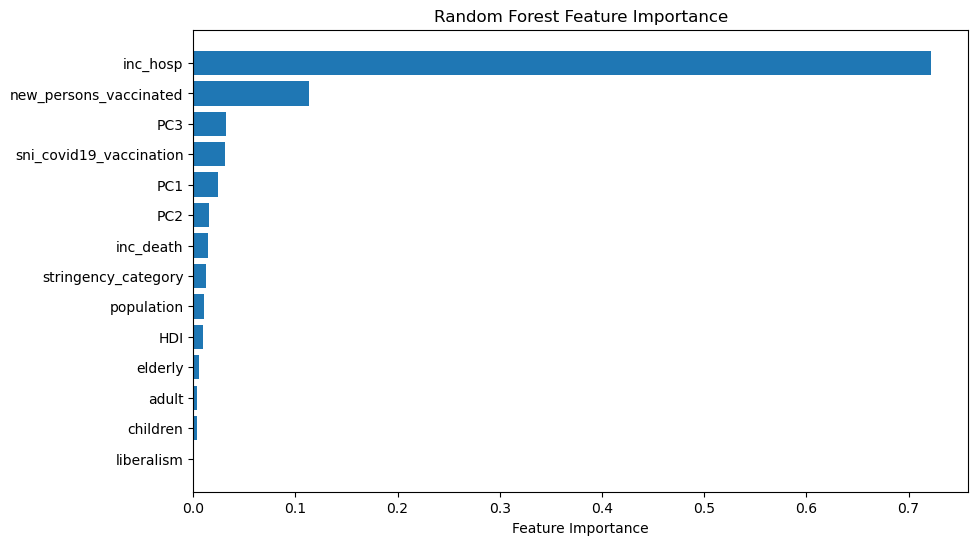

In [689]:
# Get feature importances from the random forest model
feature_importances = rf_model.feature_importances_

# Get the names of features
feature_names = list(X.columns)

# Sort features based on importance
sorted_idx = feature_importances.argsort()

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), feature_importances[sorted_idx], align="center")
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importance")
plt.show()

#### **EXTRA: Try to combine interaction variables, reweighting, and HDI**

In [690]:
# Define features and target variable
X = df[['sni_covid19_vaccination', 'new_persons_vaccinated', 'stringency_index', 'inc_death',
        'PC1', 'PC2', 'PC3', 'inc_hosp', 'children', 'adult', 'elderly', 'population', 'HDI',
        'int:liberalism_stringency', 'int:liberalsim_new_persons_vaccinated', 'int:population__stringency']]
y = df['inc_case']
sensitive_feature = df['liberalism']

# Initialize StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store predictions and true values for each fold
y_pred_list = []
y_true_list = []
liberal_mae_list = []
conservative_mae_list = []

for train_index, test_index in skf.split(X, sensitive_feature):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Calculate the sample weights based on the training data
    liberal_count_train = sum(df.loc[X_train.index]['liberalism'] == 1)
    conservative_count_train = sum(df.loc[X_train.index]['liberalism'] == 0)

    liberal_weight_train = (1 / liberal_count_train) ** 0.5
    conservative_weight_train = (1 / conservative_count_train) ** 0.5

    # Assign sample weights
    sample_weight_train = np.array([liberal_weight_train if label == 1 else conservative_weight_train for label in df.loc[X_train.index]['liberalism']])
    
    # Train RandomForestRegressor with reweighting
    rf_model = RandomForestRegressor(random_state=42)
    rf_model.fit(X_train, y_train, sample_weight=sample_weight_train)
    y_pred = rf_model.predict(X_test)

    y_pred_list.append(y_pred)
    y_true_list.append(y_test)

    # Convert y_pred to a pandas Series with the same index as y_test
    y_pred_series = pd.Series(y_pred, index=y_test.index)

    # Separate the predictions into red and blue states
    liberal_indices = X_test[df.loc[X_test.index]['liberalism'] == 1].index
    conservative_indices = X_test[df.loc[X_test.index]['liberalism'] == 0].index

    # Calculate MAE for liberal (blue) states
    liberal_mae = mean_absolute_error(y_test.loc[liberal_indices], y_pred_series.loc[liberal_indices])
    liberal_mae_list.append(liberal_mae)

    # Calculate MAE for conservative (red) states
    conservative_mae = mean_absolute_error(y_test.loc[conservative_indices], y_pred_series.loc[conservative_indices])
    conservative_mae_list.append(conservative_mae)

# Calculate the mean and standard deviation of the MAEs
mean_liberal_mae = np.mean(liberal_mae_list)
mean_conservative_mae = np.mean(conservative_mae_list)
mae_difference = mean_liberal_mae - mean_conservative_mae

print(f"Mean MAE for liberal (blue) states: {mean_liberal_mae}")
print(f"Mean MAE for conservative (red) states: {mean_conservative_mae}")
print(f"Difference in MAE (liberal - conservative): {mae_difference}")

Mean MAE for liberal (blue) states: 36635.68323544433
Mean MAE for conservative (red) states: 22341.0517633243
Difference in MAE (liberal - conservative): 14294.631472120032


In [691]:
# Lists to store evaluation metrics for liberal and conservative states in each fold
liberal_mse_list = []
liberal_rmse_list = []
liberal_coverage_list = []
liberal_bias_list = []

conservative_mse_list = []
conservative_rmse_list = []
conservative_coverage_list = []
conservative_bias_list = []

# Loop through each fold of StratifiedKFold
for fold_idx, (train_index, test_index) in enumerate(skf.split(X, sensitive_feature)):
    # Get predictions from the first part
    y_pred = y_pred_list[fold_idx]
    y_test = y_true_list[fold_idx]
    sensitive_feature = sensitive_feature_list[fold_idx]

    # Calculate RMSE, coverage, and bias for liberal and conservative states
    liberal_indices = sensitive_feature == 1
    conservative_indices = sensitive_feature == 0

    liberal_mse = mean_squared_error(y_test[liberal_indices], y_pred[liberal_indices])
    liberal_rmse = np.sqrt(liberal_mse)
    liberal_coverage, liberal_bias = calculate_coverage_bias(y_test[liberal_indices], y_pred[liberal_indices])

    conservative_mse = mean_squared_error(y_test[conservative_indices], y_pred[conservative_indices])
    conservative_rmse = np.sqrt(conservative_mse)
    conservative_coverage, conservative_bias = calculate_coverage_bias(y_test[conservative_indices], y_pred[conservative_indices])

    # Append evaluation metrics to the corresponding lists
    liberal_mse_list.append(liberal_mse)
    liberal_rmse_list.append(liberal_rmse)
    liberal_coverage_list.append(liberal_coverage)
    liberal_bias_list.append(liberal_bias)

    conservative_mse_list.append(conservative_mse)
    conservative_rmse_list.append(conservative_rmse)
    conservative_coverage_list.append(conservative_coverage)
    conservative_bias_list.append(conservative_bias)

# Calculate the mean and standard deviation of the evaluation metrics
mean_liberal_mse = np.mean(liberal_mse_list)
mean_liberal_rmse = np.mean(liberal_rmse_list)
mean_liberal_coverage = np.mean(liberal_coverage_list)
mean_liberal_bias = np.mean(liberal_bias_list)

mean_conservative_mse = np.mean(conservative_mse_list)
mean_conservative_rmse = np.mean(conservative_rmse_list)
mean_conservative_coverage = np.mean(conservative_coverage_list)
mean_conservative_bias = np.mean(conservative_bias_list)

# Print the results
print("Metrics for Liberal (Blue) States:")
print("Mean MSE:", mean_liberal_mse)
print("Mean RMSE:", mean_liberal_rmse)
print("Mean Coverage:", mean_liberal_coverage)
print("Mean Bias:", mean_liberal_bias)
print("\nMetrics for Conservative (Red) States:")
print("Mean MSE:", mean_conservative_mse)
print("Mean RMSE:", mean_conservative_rmse)
print("Mean Coverage:", mean_conservative_coverage)
print("Mean Bias:", mean_conservative_bias)

Metrics for Liberal (Blue) States:
Mean MSE: 18145377192.329006
Mean RMSE: 122903.40638124214
Mean Coverage: 0.9954545454545455
Mean Bias: -7998.692391215525

Metrics for Conservative (Red) States:
Mean MSE: 3995326736.506713
Mean RMSE: 58635.369884586675
Mean Coverage: 0.9877145438121048
Mean Bias: 5348.26384582957


In [692]:
# Create a DataFrame to store the mean evaluation metrics
metrics_df = pd.DataFrame({
    'Metric': ['MSE', 'RMSE', 'Coverage', 'Bias'],
    'Liberal (Blue) States': [mean_liberal_mse, mean_liberal_rmse, mean_liberal_coverage, mean_liberal_bias],
    'Conservative (Red) States': [mean_conservative_mse, mean_conservative_rmse, mean_conservative_coverage, mean_conservative_bias]
})

metrics_df['Difference'] = metrics_df['Liberal (Blue) States'] - metrics_df['Conservative (Red) States']

# Print the DataFrame
display(metrics_df)

,Metric,Liberal (Blue) States,Conservative (Red) States,Difference
0,MSE,1.814538e+10,3.995327e+09,1.415005e+10
1,RMSE,1.229034e+05,5.863537e+04,6.426804e+04
2,Coverage,9.954545e-01,9.877145e-01,7.740002e-03
3,Bias,-7.998692e+03,5.348264e+03,-1.334696e+04
